### Where does sea-ice in Canada Basin come from and go?

Runs to do:
- Canada Basin GEOTRACES stations --- trace ice backwards for which regions contribute
- Various polynyas --- trace ice forwards to identify regions that are impacted

Could link the particle tracks to where the ice melts?

In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, ErrorCode
from parcels import AdvectionRK4
from glob import glob
from mpl_toolkits.basemap import Basemap, cm
import numpy as np
from datetime import timedelta as delta
from os import path
import pickle
import netCDF4 as nc
import cmocean
import matplotlib.pyplot as plt
import math
import datetime

%matplotlib inline

INFO: Compiled ParcelsRandom ==> /tmp/parcels-2672/libparcels_random_51f51b31-82ad-4675-8d12-d749758e1890.so


Files from which to read velocity fields:

In [2]:
data_path = '/data/brogalla/ANHA12/'
filesU    = sorted(glob(data_path+'ANHA12-EXH006_y2013m??d??_gridU.nc')+ \
                   glob(data_path+'ANHA12-EXH006_y2014m??d??_gridU.nc')+ \
                   glob(data_path+'ANHA12-EXH006_y2015m??d??_gridU.nc'))[:-25]
filesV    = sorted(glob(data_path+'ANHA12-EXH006_y2013m??d??_gridV.nc')+ \
                   glob(data_path+'ANHA12-EXH006_y2014m??d??_gridV.nc')+ \
                   glob(data_path+'ANHA12-EXH006_y2015m??d??_gridV.nc'))[:-25]
filesW    = sorted(glob(data_path+'ANHA12-EXH006_5d_gridW_y2013m*') + \
                   glob(data_path+'ANHA12-EXH006_5d_gridW_y2014m*') + \
                   glob(data_path+'ANHA12-EXH006_5d_gridW_y2015m*'))[:-25]

In [3]:
mesh = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_lon = np.array(mesh.variables['nav_lon'])
mesh_lat = np.array(mesh.variables['nav_lat'])
mesh_dep = np.array(mesh.variables['gdept_1d'])[0,:]

mesh_mask = '/ocean/brogalla/GEOTRACES/parcels/parcels_mesh-mask.nc'

Define variables and dimensions from above files:

In [4]:
filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': filesW[0], 'data': filesU},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': filesW[0], 'data': filesV},
             'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': filesW[0], 'data': filesW}}

variables = {'U': 'vozocrtx',
             'V': 'vomecrty',
             'W': 'vovecrtz'}

dimensions= {'U': {'time': 'time_counter', 'depth':'depthw', 'lat': 'nav_lat', 'lon': 'nav_lon'},
             'V': {'time': 'time_counter', 'depth':'depthw', 'lat': 'nav_lat', 'lon': 'nav_lon'},
             'W': {'time': 'time_counter', 'depth':'depthw', 'lat': 'nav_lat', 'lon': 'nav_lon'}}

fieldset  = FieldSet.from_nemo(filenames, variables, dimensions)

Initial particle positions and release times

In [5]:
release_lons   = [-129.21, -140.03, -150.01]
release_lats   = [75.81, 76.98, 74.99]
release_depths = mesh_dep[23:31]

# release_lon_CB    = len(release_depths)*list(release_lons)
# release_lat_CB    = len(release_depths)*list(release_lats)
release_lon_CB    = np.repeat(release_lons, len(release_depths))
release_lat_CB    = np.repeat(release_lats, len(release_depths))
release_depths_CB = np.tile(release_depths, len(release_lons))
release_time = 7*delta(days=30).total_seconds() #datetime.datetime(2002,1,1)  

Functions

In [8]:
def DeleteParticle(particle, fieldset, time):
    print("Particle [%d] lost !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))
    particle.delete()

In [9]:
def load_tracks(filename):
    nemo_file  = nc.Dataset(filename)

    traj = np.array(nemo_file.variables['trajectory']) # dimensions: number of particles, tracks
    time = np.array(nemo_file.variables['time'])       # units: seconds
    lat  = np.array(nemo_file.variables['lat'])        # degrees North
    lon  = np.array(nemo_file.variables['lon'])        # degrees East
    dep  = np.array(nemo_file.variables['z'])

    return traj, time, lon, lat, dep

Notes:
- dt       --- the timestep of the kernel
- runtime  --- the total length of the run
- recovery --- what to do when an error is raised

###  Trace wBSW at GEOTRACES Canada Basin stations backwards to see when they were in the Chukchi shelf region

In [9]:
# Make sure that -180 degrees West is equal to 180 degrees East
def periodicBC(particle, fieldset, time):
    if particle.lon > 180:
        particle.lon -= 360

In [42]:
pset  = ParticleSet.from_list(fieldset=fieldset,  
                                 pclass=JITParticle,     
                                 lon=release_lon_CB,     
                                 lat=release_lat_CB,
                                 depth=release_depths_CB)

output_file = pset.ParticleFile(name="stations-CB-backwards-fday.nc", outputdt=delta(days=1))
kernels     = pset.Kernel(AdvectionRK4) + periodicBC

In [43]:
pset.execute(kernels, dt=-delta(days=5), endtime=0, output_file=output_file, 
                recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
output_file.export()

INFO: Compiled JITParticleAdvectionRK4periodicBC ==> /tmp/parcels-2672/c7867f42f2207add00e324b323b8d5c5_0.so
INFO: Temporary output files are stored in out-KCMDXGNA.
INFO: You can use "parcels_convert_npydir_to_netcdf out-KCMDXGNA" to convert these to a NetCDF file during the run.
100% (83376000.0 of 83376000.0) |########| Elapsed Time: 1:33:46 Time:  1:33:46


Look at tracks

In [10]:
CB_traj, CB_time, CB_lon, CB_lat, CB_dep = load_tracks('stations-CB-backwards.nc')

In [11]:
print(CB_time[0,0]/(3600*24*365))

2.643835616438356


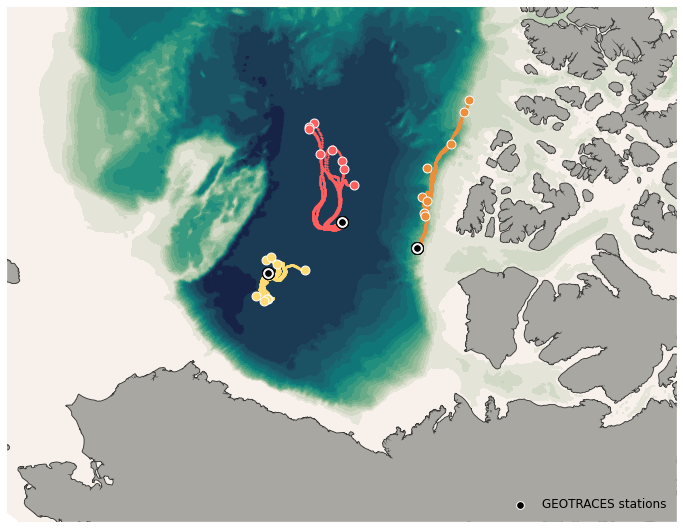

In [26]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/tracks-CB.pickle','rb'))

timemax=int(365*6/12)
x_CB, y_CB       = proj1(CB_lon[:,0:timemax], CB_lat[:,0:timemax])
x_start, y_start = proj1(CB_lon[:,0], CB_lat[:,0])
x_end,   y_end   = proj1(CB_lon[:,timemax]  , CB_lat[:,timemax])
        
a = len(release_depths)
for i in range(0, CB_lon.shape[0]):
    if i < a:
        proj1.scatter(x_CB[i,:] , y_CB[i,:]  , s=1.5, c='#ee8e3b', zorder=2)
        proj1.scatter(x_start[i], y_start[i] , s=140 , zorder=3, c='w', edgecolor='k')
        proj1.scatter(x_end[i]  , y_end[i]   , s=80 , zorder=3, c='#ee8e3b', edgecolor='w')
    elif (i >= a) and (i < 2*a):        
        proj1.scatter(x_CB[i,:] , y_CB[i,:]  , s=1.5, c='#FF5F5F', zorder=2)
        proj1.scatter(x_start[i], y_start[i] , s=140 , zorder=3, c='w', edgecolor='k')
        proj1.scatter(x_end[i]  , y_end[i]   , s=80 , zorder=3, c='#FF5F5F', edgecolor='w')
    elif (i >= 2*a):        
        proj1.scatter(x_CB[i,:] , y_CB[i,:]  , s=1.5, c='#ffdc73', zorder=2)
        proj1.scatter(x_start[i], y_start[i] , s=140 , zorder=3, c='w', edgecolor='k')
        proj1.scatter(x_end[i]  , y_end[i]   , s=80 , zorder=3, c='#ffdc73', edgecolor='w')
        

x_stns, y_stns = proj1(release_lon_CB, release_lat_CB)
proj1.scatter(x_stns, y_stns, s=60, zorder=3, c='k', edgecolor='w', label='GEOTRACES stations')
        
ax1.legend(loc=4, frameon=False, fontsize=12)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/tracks_wBSW_6months.png', bbox_inches='tight', dpi=300)

In [28]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [29]:
# Distance along track
def TotalDistance(particle_lons, particle_lats):
    
    particle_lons = particle_lons[~np.isnan(particle_lons)]
    particle_lats = particle_lats[~np.isnan(particle_lats)]
    
    particle_prev_lon = particle_lons[0]
    particle_prev_lat = particle_lats[0]
    particle_distance = 0
    
    for particle_lon, particle_lat in zip(particle_lons, particle_lats):
        particle_distance += haversine(particle_lon, particle_lat, particle_prev_lon, particle_prev_lat)

        # Set the stored values for next iteration.
        particle_prev_lon = particle_lon
        particle_prev_lat = particle_lat
        
    return particle_distance

In [37]:
def track_distance(timemax):
    
    CB2_dist = np.zeros(release_depths.shape); CB3_dist = np.zeros(release_depths.shape); CB4_dist = np.zeros(release_depths.shape);
    for n, i in enumerate(range(0, len(release_depths))):
        CB2_dist[n]  += TotalDistance(CB_lon[i,0:timemax], CB_lat[i,0:timemax])

    for n, i in enumerate(range(len(release_depths), 2*len(release_depths))):   
        CB3_dist[n]  += TotalDistance(CB_lon[i,0:timemax], CB_lat[i,0:timemax])

    for n, i in enumerate(range(2*len(release_depths), 3*len(release_depths))):
        CB4_dist[n]  += TotalDistance(CB_lon[i,0:timemax], CB_lat[i,0:timemax])

    return CB2_dist, CB3_dist, CB4_dist

In [40]:
CB2_dist, CB3_dist, CB4_dist = track_distance(int(365))
    
print('Average path distance over first year')
print(f'- CB2: {np.average(CB2_dist,axis=0):.2f} km')
print(f'- CB3: {np.average(CB3_dist,axis=0):.2f} km')
print(f'- CB4: {np.average(CB4_dist,axis=0):.2f} km')

print('Average speed over first year')
print(f'- CB2: {np.average(CB2_dist,axis=0)/365:.2f} km per day')
print(f'- CB3: {np.average(CB3_dist,axis=0)/365:.2f} km per day')
print(f'- CB4: {np.average(CB4_dist,axis=0)/365:.2f} km per day')

Average path distance over first year
- CB2: 580.93 km
- CB3: 896.17 km
- CB4: 410.34 km
Average speed over first year
- CB2: 1.59 km per day
- CB3: 2.46 km per day
- CB4: 1.12 km per day
